In [ ]:
import numpy as np 
from tqdm import tqdm
import oct2py 

# path to local clone of epg-x repository
epgx_dir = '/Users/nmickevicius/dev/EPG-X'

with oct2py.Oct2Py() as eng:

    # add EPG-X to octave path
    eng.addpath(eng.genpath(epgx_dir), nout=0)

    # simulation parameters 
    TR = np.array([5.0])                  # repetition time [ms] 
    fa_deg = np.linspace(1.0, 90.0, 180)  # flip angle [deg]
    T1 = np.array([779.0, 779.0])         # [T1a, T1b] in [ms]
    T2 = np.array([45.0])                 # [ms]
    f = 0.117                             # pool size (M0f = 1 - f) [fraction]
    k = 4.3e-3                            # [ms^-1]
    G = 15.1                              # lineshape parameter [us]
    gam = 267.5221e-3                     # gyromagnetic ratio [rad/ms/uT]
    trf = 0.3                             # hard pulse duration [ms] 
    b1 = (fa_deg * np.pi / 180)/(trf*gam) # RF pulse amplitude to achieve each flip angle [uT]
    b1sqrdtau = (b1**2)*trf               # area under squared B1(t) waveform for each flip angle
    npulse = 1000                         # number of pulses to establish steady-state for EPG
    phi = np.zeros((npulse,))             # constant RF phase 

    # allocate simulated
    S0_epg = np.zeros((fa_deg.size,), dtype=np.complex128)
    S1_epg = np.zeros((fa_deg.size,), dtype=np.complex128)
    Sm1_epg = np.zeros((fa_deg.size,), dtype=np.complex128)

    # loop over different flip angles 
    for n in tqdm(range(fa_deg.size)):

        # constant flip angle and rf power over all TRs to establish steady state 
        alpha = (fa_deg[n]*np.pi/180) * np.ones((npulse,))
        rfpwr = b1sqrdtau[n] * np.ones((npulse,))
        output = eng.EPGX_GRE_MT(alpha, phi, rfpwr, TR, T1, T2, f, k, G, nout=4)
        Om = np.asarray(output[-1], dtype=np.complex128)

        # extract the S(k=0), S(k=-1), and S(k=+1) signals from the EPG configuration
        S0_epg[n] = Om[0,-1]
        Sm1_epg[n] = np.conj(Om[5,-1])
        S1_epg[n] = Om[4,-1]

# EPG-X uses relationship M0f = 1 - M0r, whereas analytical framework uses
# F = M0r/M0f, correct the amplitude of EPG simulations to match analytical 
S0_epg = S0_epg / (1 - f)
S1_epg = S1_epg / (1 - f)
Sm1_epg = Sm1_epg / (1 - f)

###########################################
#       Analytical Two-Pool Signals       #
###########################################

# convert restricted pool size from f --> F 
F = f / (1 - f)
M0f = 1.0 
M0r = F

# get restricted pool saturation decay term 
alpha = fa_deg * np.pi / 180
tau = trf * 1e-3
fw = np.exp(-np.pi * alpha**2 * G*1e-6 / tau)

# convert TR to seconds 
TRs = TR * 1e-3

# get exchange term 
kf = k*1e3 
kr = kf/F 
fk = np.exp(-(kf + kr) * TRs)

# relaxation terms
E1f = np.exp(-TR/T1[0])
E1r = np.exp(-TR/T1[1])
E2f = np.exp(-TR/T2)

# get the factorization terms from Gloor et al
beta1 = 1 + F - fw*E1r*(F + fk)
beta2 = 1 + fk*(F - fw*E1r*(F+1))
beta3 = E2f*(beta2*E1f - beta1)*(1 + np.cos(alpha))
beta4 = beta1 - beta2*E1f*np.cos(alpha) - (beta2*E1f - beta1*np.cos(alpha))*E2f**2
beta5 = M0f*beta2*(1 - E1f) + M0r*(1 - E1r)*(1 - fk)

# get SSFP equation coefficients
A = beta5 * np.sin(alpha)
B = beta3 
C = beta4 

# for calculation of the general S(k) expressions
u0 = C / np.sqrt(C**2 - B**2)
u1 = (C/B) * (1 - u0)

# get the triple echo steady state S(k=0), S(k=-1), S(k=+1)
S0 = (A/C) * (u0 - E2f*u1)
Sm1 = (A/C) * (u0*E2f - u1)
S1 = (u1/u0) * S0

##############################################
#       Analytical Single-Pool Signals       #
##############################################

# get SSFP equation coefficients
A = (1 - E1f) * np.sin(alpha) 
B = E2f * (E1f - 1) * (1 + np.cos(alpha))
C = 1 - E1f * np.cos(alpha) - (E1f - np.cos(alpha)) * E2f**2

# for calculation of the general S(k) expressions
u0 = C / np.sqrt(C**2 - B**2)
u1 = (C/B) * (1 - u0)

# get the triple echo steady state S(k=0), S(k=-1), S(k=+1)
S0_sp = (A/C) * (u0 - E2f*u1)
Sm1_sp = (A/C) * (u0*E2f - u1)
S1_sp = (u1/u0) * S0

# correct for effective difference between M0 between between models
S0_sp = S0_sp / (1 - f)
S1_sp = S1_sp / (1 - f)
Sm1_sp = Sm1_sp / (1 - f)


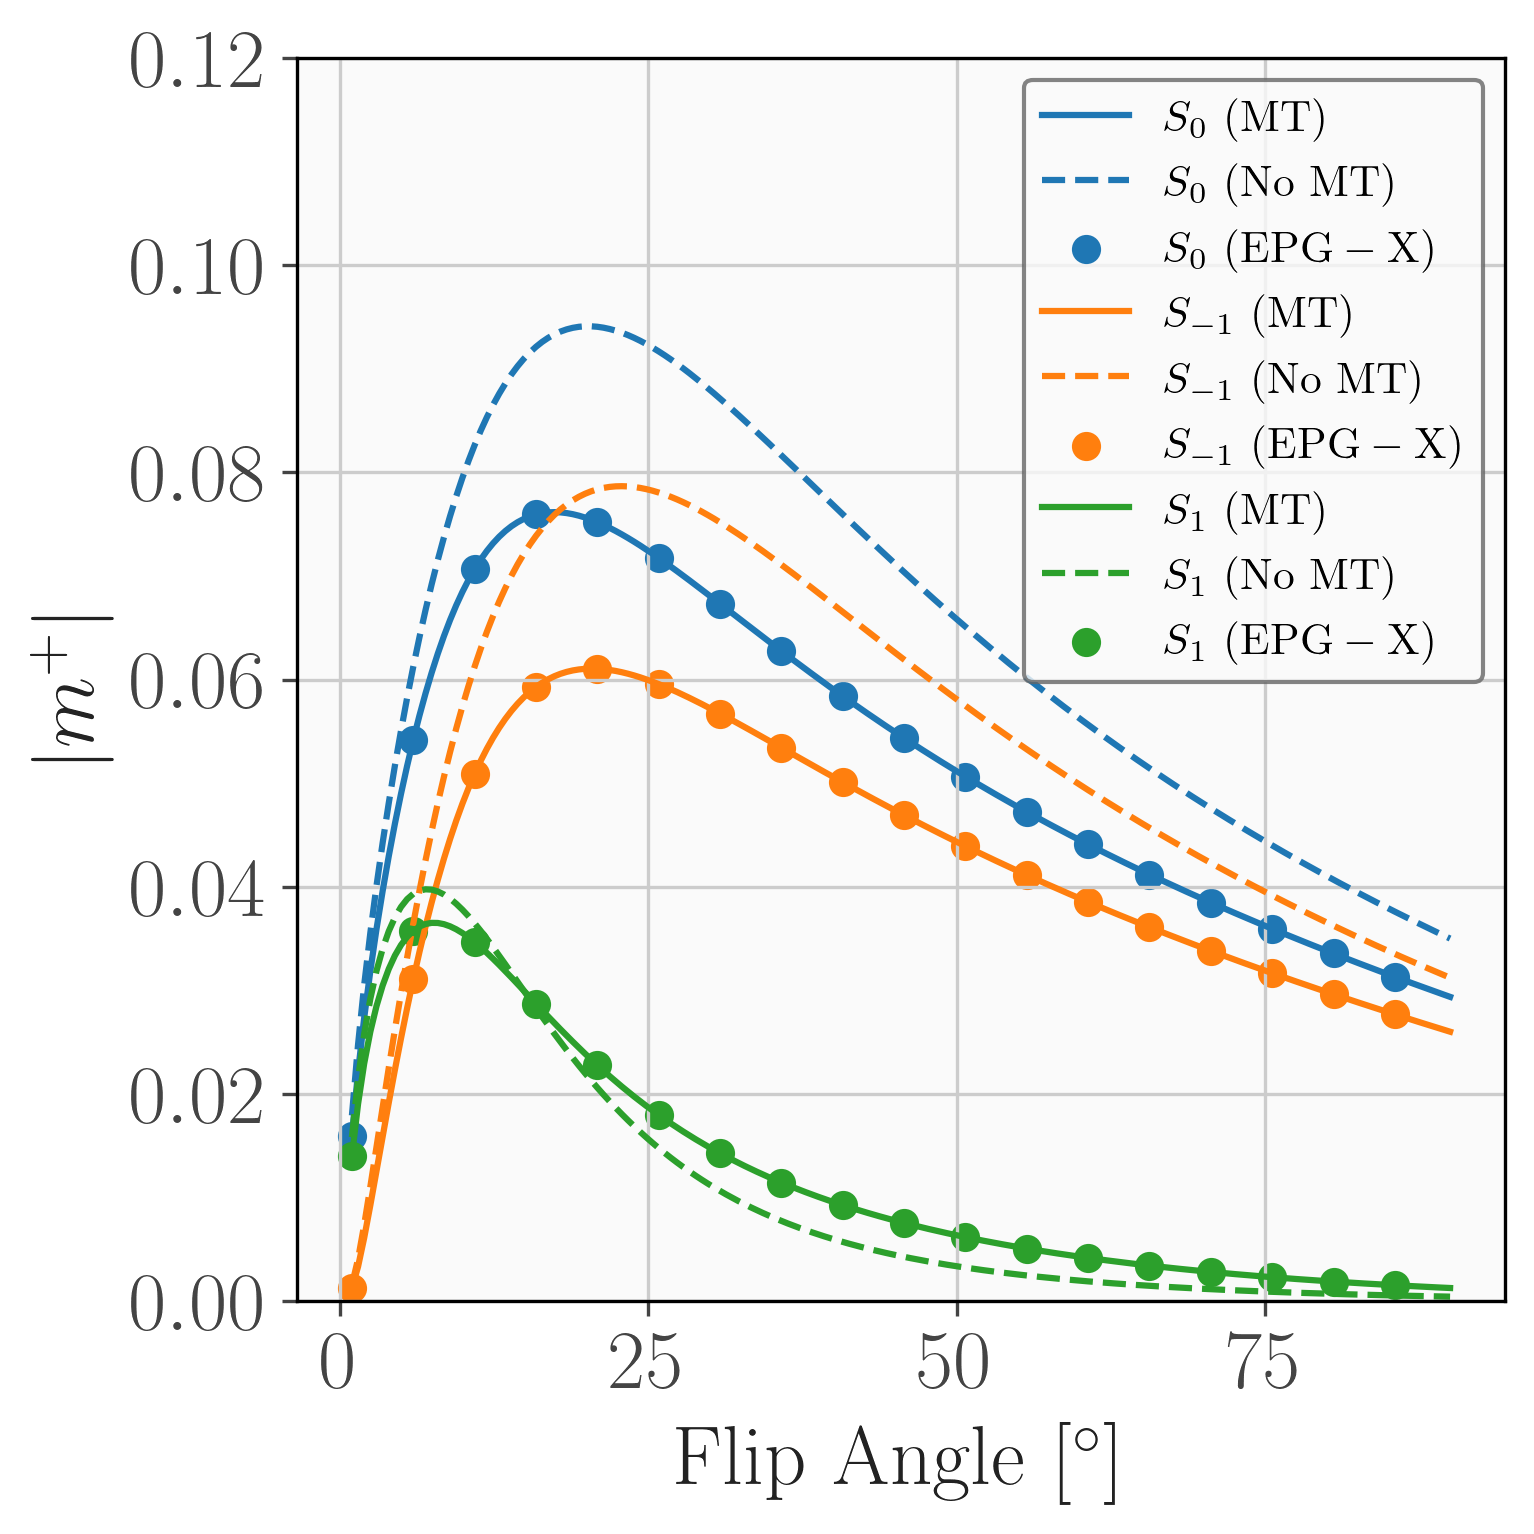

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import matplotlib.colors as mcolors 
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

use_tex = 1
plt.rcParams['text.usetex'] = use_tex
matplotlib.rcParams['font.size'] = 28         # overall font size
matplotlib.rcParams['axes.titlesize'] = 20    # size of the axes title
matplotlib.rcParams['axes.labelsize'] = 20    # size of the axis labels
matplotlib.rcParams['xtick.labelsize'] = 20   # size of the x-axis tick labels
matplotlib.rcParams['ytick.labelsize'] = 20   # size of the y-axis tick labels

plt.rcParams['figure.facecolor'] = '#ffffff'  
plt.rcParams['axes.facecolor'] = '#fafafa' 
plt.rcParams['axes.labelcolor'] = '222222'  
plt.rcParams['axes.titlecolor'] = '#000000' 
plt.rcParams['xtick.color'] = '#444444'  
plt.rcParams['ytick.color'] = '#444444'
plt.rcParams['legend.edgecolor'] = '#666666'
plt.rcParams['text.color'] = '#000000'
plt.rcParams['grid.color'] = '#cccccc' 

sp = 10

fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=300, constrained_layout=True)

c0, c1, c2 = "C0", "C1", "C2"

ax.plot(fa_deg, S0, color=c0, label=r'$S_0\mathrm{\ (MT)}$')
ax.plot(fa_deg, S0_sp, '--', color=c0, label=r'$S_0\mathrm{\ (No\ MT)}$')
ax.scatter(fa_deg[::sp], np.abs(S0_epg[::sp]), color=c0, label=r'$S_0\mathrm{\ (EPG-X)}$')

ax.plot(fa_deg, Sm1, color=c1, label=r'$S_{-1}\mathrm{\ (MT)}$')
ax.plot(fa_deg, Sm1_sp, '--', color=c1, label=r'$S_{-1}\mathrm{\ (No\ MT)}$')
ax.scatter(fa_deg[::sp], np.abs(Sm1_epg[::sp]), color=c1, label=r'$S_{-1}\mathrm{\ (EPG-X)}$')

ax.plot(fa_deg, S1, color=c2, label=r'$S_1\mathrm{\ (MT)}$')
ax.plot(fa_deg, S1_sp, '--', color=c2, label=r'$S_1\mathrm{\ (No\ MT)}$')
ax.scatter(fa_deg[::sp], np.abs(S1_epg[::sp]), color=c2, label=r'$S_1\mathrm{\ (EPG-X)}$')

ax.legend(fontsize=10.5)
ax.set_ylim(0, 0.12)
ax.set_xlabel(r'$\mathrm{Flip\ Angle\ }[^\circ]$')
ax.set_ylabel(r'$|m^+|$')
ax.grid()

figfile = 'figure_01.png'
plt.savefig(figfile)

plt.show()